c:\Users\ke119419\Documents\GitHub\kv_shift\shift\geometry.py:365: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  return ox.geometries_from_polygon(self.polygon, {"building": True})


Total number of buildings: 11419
Sample geometry: Building( Latitude = 28.555458,  Longitude = -81.5469597, Area = 0)


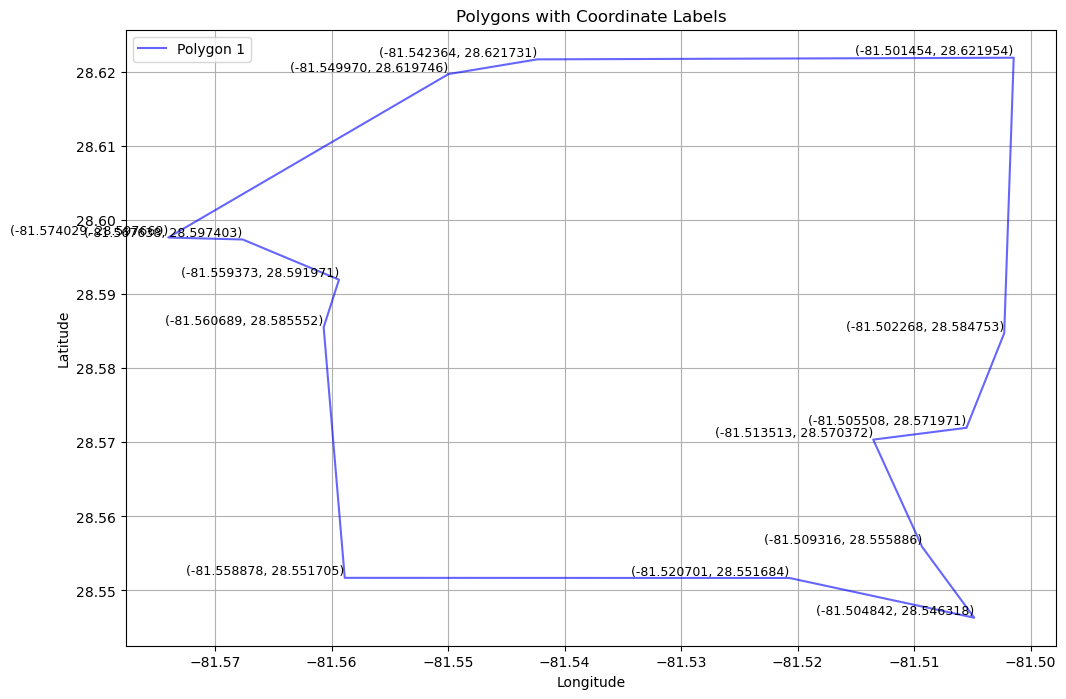

In [6]:
from shift.geometry import BuildingsFromPlace, BuildingsFromPoint,BuildingsFromPolygon
#g = BuildingsFromPlace("Oviedo, Florida", max_dist=300)
# placeOfInterest = 'Oviedo, Florida'

pointOfInterest = (28.564797, -81.455452)

# DEFINING A BOUNDING BOX DISTANCE FROM PLACE OR POINT (in meters)
maxDistance = 450

realPolygon = [ (-81.549970,28.619746),
                (-81.542364,28.621731),
                (-81.501454, 28.621954),
                (-81.502268, 28.584753),
                (-81.505508, 28.571971),
                (-81.513513, 28.570372),
                (-81.509316, 28.555886), 
                (-81.504842, 28.546318), 
                (-81.520701, 28.551684),
                (-81.558878, 28.551705),
                (-81.560689, 28.585552),
                (-81.559373, 28.591971),
                (-81.567638,28.597403),
                (-81.574029,28.597669)
]

# polygon1 = [(-81.549970,28.619746),
# (-81.574029,28.597669),
# (-81.567638,28.597403),
# (-81.561926,28.594233),
# (-81.559373, 28.591971),
# (-81.560346,28.586886),
# (-81.503149,28.588783),
# (-81.501454, 28.621954),
# (-81.542364,28.621731)]


# polygon = [(-81.560689, 28.585552), 
# (-81.502268, 28.584753),
# (-81.505508, 28.571971),
# (-81.513513, 28.570372),
# (-81.509316, 28.555886), 
# (-81.504842, 28.546318), 
# (-81.520701, 28.551684),
# (-81.558878, 28.551705)]

# polygon2 = [(-81.560689, 28.585552), 
# (-81.502268, 28.584753),
# (-81.505508, 28.571971),
# (-81.513513, 28.570372),
# (-81.509316, 28.555886), 
# (-81.504842, 28.546318), 
# (-81.520701, 28.551684),
# (-81.558878, 28.551705)]
#g = BuildingsFromPoint(pointOfInterest, max_dist=maxDistance)
g = BuildingsFromPolygon(polygon=realPolygon)

geometries = g.get_geometries()
print(f"Total number of buildings: {len(geometries)}" +
f"\nSample geometry: {geometries[0]}")
# Extract longitudes and latitudes for easy plotting
def extract_coordinates(polygon):
    lon, lat = zip(*polygon)
    return lon, lat

lon1, lat1 = extract_coordinates(realPolygon)
import matplotlib.pyplot as plt


# Plot the polygons
plt.figure(figsize=(12, 8))
plt.plot(lon1 + (lon1[0],), lat1 + (lat1[0],), 'b-', label='Polygon 1', alpha=0.6)
# Label each point with its coordinates
for lon, lat in realPolygon:
    plt.text(lon, lat, f"({lon:.6f}, {lat:.6f})", fontsize=9, ha='right', va='bottom')

# Add labels, legend, and grid
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Polygons with Coordinate Labels')
plt.legend(loc='best')
plt.grid(True)

# Display the plot
plt.show()


In [14]:
from shift.load_builder import (RandomPhaseAllocator, 
                                SimpleVoltageSetter, DefaultConnSetter)
rpa = RandomPhaseAllocator(100,0,0, geometries)
svs = SimpleVoltageSetter(0.4)
dcs = DefaultConnSetter()


In [15]:
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd

area_to_kw_curve = [(0,5), (10, 5.0), (20, 18), (50, 30)]

df = pd.DataFrame({
    'Area in meter square' : [x[0] for x in area_to_kw_curve],
    'Peak consumption in kW' : [x[1] for x in area_to_kw_curve]
})
fig = px.line(df, x="Area in meter square", y="Peak consumption in kW") 
fig.show()


In [16]:
from shift.load_builder import PiecewiseBuildingAreaToConsumptionConverter
pbacc = PiecewiseBuildingAreaToConsumptionConverter(area_to_kw_curve)
area = 15
print(f"For area of {area} m^2 the consumption would be {pbacc.convert(area)}")


For area of 15 m^2 the consumption would be 11.5


In [17]:
from shift.load_builder import ConstantPowerFactorBuildingGeometryLoadBuilder
from shift.load_builder import LoadBuilderEngineer
loads = []
for g in geometries:
    builder = ConstantPowerFactorBuildingGeometryLoadBuilder(g, rpa, pbacc, svs, dcs, 1.0)
    b = LoadBuilderEngineer(builder)
    loads.append(b.get_load())
print(len(loads), loads[0], loads[1])


4966 ConstantPowerFactorLoad(Name = -81.52755999064091_28.583955374544328_load, Latitude = 28.583955374544328, Longitude = -81.52755999064091, Phase = Phase.BN NumPhase = NumPhase.SINGLE, Connection Type = LoadConnection.STAR, kw = 5.0, pf = 1.0, kv = 0.231) ConstantPowerFactorLoad(Name = -81.53125420216016_28.55887066179358_load, Latitude = 28.55887066179358, Longitude = -81.53125420216016, Phase = Phase.BN NumPhase = NumPhase.SINGLE, Connection Type = LoadConnection.STAR, kw = 5.0, pf = 1.0, kv = 0.231)


In [18]:
from shift.feeder_network import (SimpleTwoLayerDistributionNetworkBuilder, 
                                  TwoLayerNetworkBuilderDirector)
from shift.network_plots import PlotlyGISNetworkPlot
from shift.constants import PLOTLY_FORMAT_CUSTOMERS_ONLY

network_builder = SimpleTwoLayerDistributionNetworkBuilder()
network = TwoLayerNetworkBuilderDirector(loads, [], [], [], network_builder)

API_KEY = None
p = PlotlyGISNetworkPlot(
        network.get_network(),
        API_KEY,
        'open-street-map',
        asset_specific_style=PLOTLY_FORMAT_CUSTOMERS_ONLY
    )
p.show()


In [19]:
from shift.clustering import KmeansClustering
import numpy as np

x_array = np.array([[load.longitude, load.latitude] 
                    for load in loads])
cluster_ = KmeansClustering(4)
clusters = cluster_.get_clusters(x_array)
cluster_.plot_clusters()


c:\Users\ke119419\AppData\Local\anaconda3\envs\shift\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=20.



In [20]:
from shift.transformer_builder import (
    ClusteringBasedTransformerLoadMapper)
from shift.enums import (TransformerConnection, 
                         NumPhase, Phase)
from shift.constants import (
    PLOTLY_FORMAT_CUSTOMERS_AND_DIST_TRANSFORMERS_ONLY)

trans_builder = ClusteringBasedTransformerLoadMapper(
    loads,
    clustering_object = cluster_,
    diversity_factor_func = lambda x: 0.3908524*np.log(x) + 1.65180707,
    ht_kv = 11,
    lt_kv = 0.4,
    ht_conn = TransformerConnection.DELTA,
    lt_conn = TransformerConnection.STAR,
    ht_phase = Phase.ABC,
    lt_phase = Phase.ABC,
    num_phase = NumPhase.THREE,
    power_factor=1,
    adjustment_factor=1.15
)
t  = trans_builder.get_transformer_load_mapping()

network = TwoLayerNetworkBuilderDirector(loads, 
            list(t.keys()), [], [], network_builder)
p = PlotlyGISNetworkPlot(
        network.get_network(),
        API_KEY,
        'open-street-map',
        asset_specific_style=PLOTLY_FORMAT_CUSTOMERS_AND_DIST_TRANSFORMERS_ONLY
    )
p.show()


c:\Users\ke119419\AppData\Local\anaconda3\envs\shift\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=20.



In [312]:
from shift.graph import RoadNetworkFromPlace, RoadNetworkFromPoint
from shift.constants import PLOTLY_FORMAT_SIMPLE_NETWORK
#graph = RoadNetworkFromPlace('chennai, india', max_dist=300)
graph = RoadNetworkFromPoint(pointOfInterest, max_dist=maxDistance)
graph.get_network()
p = PlotlyGISNetworkPlot(
            graph.updated_network,
            API_KEY,
            'open-street-map',
            asset_specific_style=PLOTLY_FORMAT_SIMPLE_NETWORK
        )
p.show()


c:\Users\ke119419\AppData\Local\anaconda3\envs\shift\lib\site-packages\osmnx\graph.py:191: FutureWarning:

The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.



In [313]:
from shift.primary_network_builder import PrimaryNetworkFromRoad
pnet = PrimaryNetworkFromRoad(
        graph,
        t,
        (-81.407892,28.498431),
        lambda x: 0.3908524*np.log(x) + 1.65180707,
        11,
        100
    )
pnet.update_network_with_ampacity()
p = PlotlyGISNetworkPlot(
            pnet.get_primary_network(),
            API_KEY,
            'open-street-map',
            asset_specific_style=PLOTLY_FORMAT_SIMPLE_NETWORK
        )
p.show()


c:\Users\ke119419\AppData\Local\anaconda3\envs\shift\lib\site-packages\osmnx\graph.py:191: FutureWarning:

The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.

c:\Users\ke119419\Documents\GitHub\shift\shift\primary_network_builder.py:774: FutureWarning:

steiner_tree will change default method from 'kou' to 'mehlhorn' in version 3.2.
Set the `method` kwarg to remove this warning.



In [314]:
from shift.primary_network_builder import PrimarySectionsBuilder
from shift.enums import ConductorType, NumPhase
from shift.line_section import HorizontalThreePhaseConfiguration
from shift.feeder_network import update_transformer_locations
psections = PrimarySectionsBuilder(
    pnet.get_network(),
    ConductorType.OVERHEAD,
    {NumPhase.THREE: HorizontalThreePhaseConfiguration(9, 0.4, "m")},
    NumPhase.THREE,
    Phase.ABC,
    False,
    material="ACSR",
)
longest_length = pnet.get_longest_length_in_kvameter() / 1609.34
k_drop = 2 / (longest_length)
l_sections = psections.generate_primary_line_sections(k_drop, 11.0)
r_nodes = pnet.get_trans_node_mapping()
psections


In [315]:
t = update_transformer_locations(r_nodes, t, l_sections)


In [316]:
from shift.secondary_network_builder import (SecondaryNetworkBuilder, 
    SecondarySectionsBuilder)
from shift.line_section import (HorizontalThreePhaseNeutralConfiguration, 
    HorizontalSinglePhaseConfiguration)
s_sections = []
counter = 0
load_to_node_mapping_dict = {}
for trans, cust_list in t.items():
    sn = SecondaryNetworkBuilder(cust_list, trans, 
        lambda x: 0.3908524*np.log(x) + 1.65180707, 0.4, f"_secondary_{counter}")
    sn.update_network_with_ampacity()
    load_to_node_mapping_dict.update(sn.get_load_to_node_mapping())
    k_drop = 5 / (200 * 2)
    sc = SecondarySectionsBuilder(
        sn.get_network(),
        ConductorType.OVERHEAD,
        {
            NumPhase.THREE: HorizontalThreePhaseNeutralConfiguration(
                9, 0.4, 9.4, "m"
            )
        },
        {
            NumPhase.SINGLE: HorizontalSinglePhaseConfiguration(9, "m"),
        },
        NumPhase.THREE,
        Phase.ABCN,
        True,
        material="ACSR"
    )
    s_sections.extend(sc.generate_secondary_line_sections(k_drop, 0.4))
    counter +=1


Vertical distance 541.0887368154691m, Horizontal distance 658.7303505736134m
Vertical sections: 16,horizontal sections: 20
The node -81.38896651200443_28.53029672031843__secondary_0_node is not in the graph.
The node -81.38896651200443_28.529991580477642__secondary_0_node is not in the graph.
The node -81.38896651200443_28.52968644063686__secondary_0_node is not in the graph.
The node -81.38896651200443_28.530601860159212__secondary_0_node is not in the graph.
The node -81.38863001333826_28.530601860159212__secondary_0_node is not in the graph.
The node -81.38896651200443_28.53029672031843__secondary_0_node is not in the graph.
The node -81.3893030106706_28.53029672031843__secondary_0_node is not in the graph.
The node -81.38963950933677_28.53029672031843__secondary_0_node is not in the graph.
The node -81.38997600800295_28.53029672031843__secondary_0_node is not in the graph.
The node -81.39031250666912_28.53029672031843__secondary_0_node is not in the graph.
The node -81.388630013338

c:\Users\ke119419\Documents\GitHub\shift\shift\utils.py:514: FutureWarning:

steiner_tree will change default method from 'kou' to 'mehlhorn' in version 3.2.
Set the `method` kwarg to remove this warning.



Vertical distance 543.557726549544m, Horizontal distance 559.37237655227m
Vertical sections: 16,horizontal sections: 17
The node -81.39301800730351_28.530323411470324__secondary_1_node is not in the graph.
The node -81.39301800730351_28.530629943664405__secondary_1_node is not in the graph.
The node -81.39301800730351_28.530016879276246__secondary_1_node is not in the graph.
The node -81.39738820561868_28.529710347082165__secondary_1_node is not in the graph.
The node -81.39705203651752_28.529710347082165__secondary_1_node is not in the graph.
The node -81.39705203651752_28.529710347082165__secondary_1_node is not in the graph.
The node -81.39738820561868_28.529710347082165__secondary_1_node is not in the graph.
The node -81.39705203651752_28.529710347082165__secondary_1_node is not in the graph.
The node -81.39705203651752_28.530016879276246__secondary_1_node is not in the graph.
The node -81.39503502191052_28.528790750499923__secondary_1_node is not in the graph.
The node -81.3946988

c:\Users\ke119419\Documents\GitHub\shift\shift\utils.py:514: FutureWarning:

steiner_tree will change default method from 'kou' to 'mehlhorn' in version 3.2.
Set the `method` kwarg to remove this warning.



Vertical distance 622.6250638803358m, Horizontal distance 649.560023708391m
Vertical sections: 19,horizontal sections: 20
The node -81.38756998392128_28.53275796958023__secondary_2_node is not in the graph.
The node -81.38723815326775_28.53275796958023__secondary_2_node is not in the graph.
The node -81.38723815326775_28.5330536503245__secondary_2_node is not in the graph.
The node -81.38756998392128_28.5330536503245__secondary_2_node is not in the graph.
The node -81.38723815326775_28.5330536503245__secondary_2_node is not in the graph.
The node -81.38756998392128_28.53275796958023__secondary_2_node is not in the graph.
The node -81.38723815326775_28.53275796958023__secondary_2_node is not in the graph.
The node -81.38756998392128_28.532462288835966__secondary_2_node is not in the graph.
The node -81.38723815326775_28.532462288835966__secondary_2_node is not in the graph.
The node -81.38756998392128_28.532166608091696__secondary_2_node is not in the graph.
The node -81.38723815326775_

c:\Users\ke119419\Documents\GitHub\shift\shift\utils.py:514: FutureWarning:

steiner_tree will change default method from 'kou' to 'mehlhorn' in version 3.2.
Set the `method` kwarg to remove this warning.



Vertical distance 605.1346727640268m, Horizontal distance 543.2321694067592m
Vertical sections: 18,horizontal sections: 16
The node -81.39253339090939_28.533151364280457__secondary_3_node is not in the graph.
The node -81.39253339090939_28.533454704207994__secondary_3_node is not in the graph.
The node -81.39253339090939_28.53436472399061__secondary_3_node is not in the graph.
The node -81.39288028181879_28.534668063918147__secondary_3_node is not in the graph.
The node -81.39253339090939_28.534668063918147__secondary_3_node is not in the graph.
The node -81.39288028181879_28.53284802435292__secondary_3_node is not in the graph.
The node -81.39288028181879_28.533151364280457__secondary_3_node is not in the graph.
The node -81.3932271727282_28.53284802435292__secondary_3_node is not in the graph.
The node -81.39288028181879_28.53284802435292__secondary_3_node is not in the graph.
The node -81.39288028181879_28.533151364280457__secondary_3_node is not in the graph.
The node -81.395308518

c:\Users\ke119419\Documents\GitHub\shift\shift\utils.py:514: FutureWarning:

steiner_tree will change default method from 'kou' to 'mehlhorn' in version 3.2.
Set the `method` kwarg to remove this warning.



In [317]:
from shift.transformer_builder import SingleTransformerBuilder
s_node = pnet.substation_node
s_coords = pnet.substation_coords
sub_trans_builder = SingleTransformerBuilder(
    loads,
    s_coords[0],
    s_coords[1],
    diversity_factor_func=lambda x: 0.3908524 * np.log(x) + 1.65180707,
    ht_kv=33,
    lt_kv=11,
    ht_conn=TransformerConnection.DELTA,
    lt_conn=TransformerConnection.STAR,
    ht_phase=Phase.ABC,
    lt_phase=Phase.ABCN,
    num_phase=NumPhase.THREE,
    power_factor=1,
    adjustment_factor=1.15,
)
st = sub_trans_builder.get_transformer_load_mapping()


In [318]:
from shift.exporter.opendss import (
ConstantPowerFactorLoadWriter,
TwoWindingSimpleTransformerWriter,
GeometryBasedLineWriter,
OpenDSSExporter
)
lw = ConstantPowerFactorLoadWriter(
    loads, load_to_node_mapping_dict, "loads.dss"
)
tw = TwoWindingSimpleTransformerWriter(list(t.keys()), "dist_xfmrs.dss")
stw = TwoWindingSimpleTransformerWriter(list(st.keys()), "sub_trans.dss")
sw = GeometryBasedLineWriter(
    l_sections + s_sections,
    line_file_name="lines.dss",
    geometry_file_name="line_geometry.dss",
    wire_file_name="wiredata.dss",
    cable_file_name="cabledata.dss",
)


dw = OpenDSSExporter(
    [tw, stw, sw, lw],
    r"C:\Users\ke119419\Documents\GitHub\shift\output\caseStudy3",
    "master.dss",
    "orlando",
    33.0,
    60,
    Phase.ABCN,
    NumPhase.THREE,
    f"{s_node.split('_')[0]}_{s_node.split('_')[1]}_htnode",
    [0.00, 0.001],
    [0.00, 0.001],
    [0.4, 11.0, 33.0],
)
dw.export()
